In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [19]:
if torch.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)


Using device: mps


In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [21]:
train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST(root='mnist_data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [22]:
def add_noise(img, noise_factor=0.7, device=device):
    noisy_img = img + noise_factor * torch.randn(*img.shape).to(device)
    noisy_img = torch.clip(noisy_img, 0., 1.)
    return noisy_img

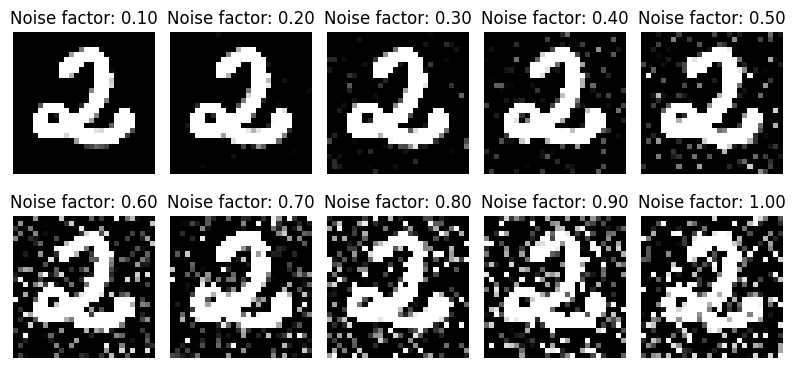

In [23]:
img, _ = next(iter(train_loader))

plt.figure(figsize=(8, 4))
for i, noise_factor in enumerate(np.linspace(0.1, 1, 10)):
    plt.subplot(2, 5, 1+i)
    plt.imshow(add_noise(img[0], noise_factor=noise_factor, device='cpu').squeeze(), cmap='gray')
    plt.title(f'Noise factor: {noise_factor:.2f}')
    plt.axis('off') 
plt.tight_layout()   
plt.show()
    

In [24]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

dummy_input = torch.randn(1, 1, 28, 28)
dummy_model = Autoencoder()
dummy_model(dummy_input).shape

torch.Size([1, 1, 28, 28])

In [25]:
class AutoencoderV2(nn.Module):
    def __init__(self):
        super(AutoencoderV2, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        # print(x.shape)
        x = self.decoder(x)
        return x

dummy_input = torch.randn(1, 1, 28, 28)   
dummy_model = AutoencoderV2()
dummy_model(dummy_input).shape


torch.Size([1, 1, 28, 28])

In [26]:
def calc_shape_up_conv(in_shape, kernel_size, stride, padding, output_padding):
    return (in_shape - 1) * stride - 2 * padding + kernel_size + output_padding

def calc_shape_down_conv(in_shape, kernel_size, stride, padding):
    return (in_shape + 2 * padding - kernel_size) // stride + 1

calc_shape_up_conv(14, 3, 2, 1, 1)
calc_shape_down_conv(28, 3, 2, 1)

14

In [27]:
model = AutoencoderV2().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 10

In [28]:
def visualize_outputs(model, data_loader, device, title=None):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images.to(device)
        noise_factor = np.random.rand()
        noisy_images = add_noise(images, noise_factor=noise_factor)
        outputs = model(noisy_images)

        # Plot original, noisy and denoised images
        plt.figure(figsize=(9, 3))
        for i in range(5):
            # Original
            plt.subplot(3, 5, i + 1)
            plt.imshow(images[i].cpu().squeeze(), cmap='gray')
            plt.axis('off')

            # Noisy
            plt.subplot(3, 5, i + 6)
            plt.imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
            plt.axis('off')

            # Denoised
            plt.subplot(3, 5, i + 11)
            plt.imshow(outputs[i].cpu().squeeze(), cmap='gray')
            plt.axis('off')

        if title:
            plt.suptitle(title)
        plt.show()

Epoch 1/10 | Train Loss: 0.7046449598727196 | Test Loss: 0.5681298777555964


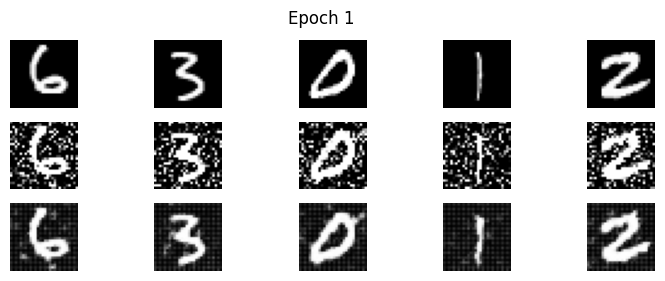

Epoch 2/10 | Train Loss: 0.5208922673199476 | Test Loss: 0.5086564467211437
Epoch 3/10 | Train Loss: 0.48985227027427414 | Test Loss: 0.49367440714957606
Epoch 4/10 | Train Loss: 0.48097718349779084 | Test Loss: 0.48661223927121255
Epoch 5/10 | Train Loss: 0.47718028667003615 | Test Loss: 0.4851198097702804


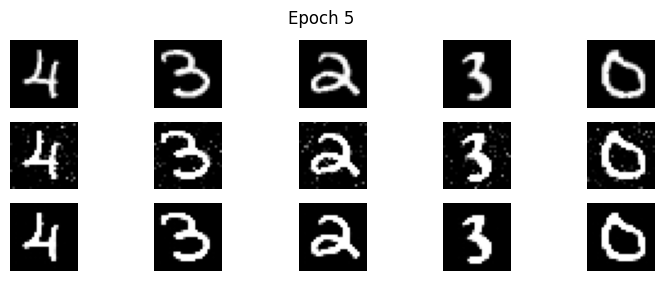

Epoch 6/10 | Train Loss: 0.4757905183379838 | Test Loss: 0.4843286890892466
Epoch 7/10 | Train Loss: 0.474202640783558 | Test Loss: 0.482395818089224
Epoch 8/10 | Train Loss: 0.47397975102543577 | Test Loss: 0.4814851274535914
Epoch 9/10 | Train Loss: 0.4736242300983685 | Test Loss: 0.4821203988828477
Epoch 10/10 | Train Loss: 0.47339506507682394 | Test Loss: 0.4821290309262124


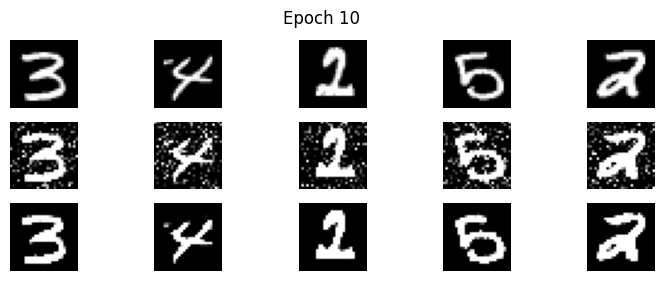

In [29]:
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for images, _ in train_loader:
        images = images.to(device)
        noise_factor = np.random.rand()
        noisy_images = add_noise(images, noise_factor)
        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            noise_factor = np.random.rand()
            noisy_images = add_noise(images, noise_factor)
            outputs = model(noisy_images)
            loss = criterion(outputs, images)

            test_loss += loss.item()
        
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f'Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss} | Test Loss: {avg_test_loss}')

    if epoch == 0 or (epoch + 1) % 5 == 0:
        visualize_outputs(model, train_loader, device, title=f'Epoch {epoch+1}')

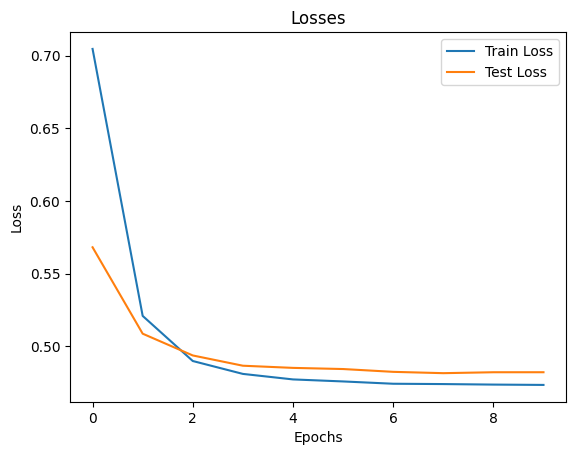

In [30]:
# plot losses
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

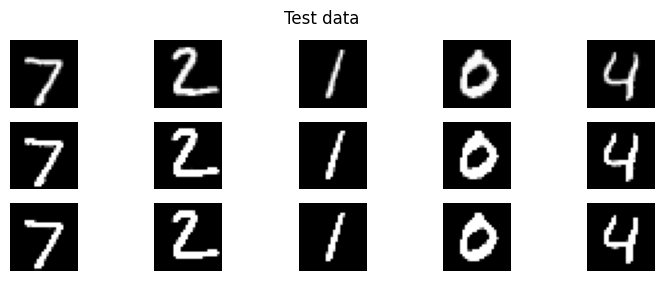

In [31]:
visualize_outputs(model, test_loader, device, title='Test data')

In [32]:
# save model state_dict
torch.save(model.state_dict(), '../models/autoencoder_0.pth')

In [33]:
# load model
model = AutoencoderV2().to(device)
model.load_state_dict(torch.load('../models/autoencoder_0.pth'))

/var/folders/_0/fx2rjf4j2nq_gd2p411c2kfw0000gp/T/ipykernel_88467/4110921420.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/a

<All keys matched successfully>

In [34]:
# v2 without 0.4815
# v2 with 0.4816
# without reducing image size 0.4792